## EXAMPLE Quadtree

In [1]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import time
import xarray as xr
import xugrid as xu

import matplotlib.pyplot as plt

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

from hydromt.log import setuplog

#### Start with a regular grid model

In [2]:
logger = setuplog("sfincs_regular", log_level=10)
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
# we overwrite (mode='w+') the existing model in the root directory if it exists
sf = SfincsModel(data_libs=["artifact_data"], root="test_regular", mode="w+", logger=logger)

2024-03-25 12:39:43,146 - sfincs_regular - log - INFO - HydroMT version: 0.9.5.dev0
2024-03-25 12:39:44,557 - sfincs_regular - data_catalog - INFO - Reading data catalog archive artifact_data v0.0.8
2024-03-25 12:39:44,559 - sfincs_regular - data_catalog - INFO - Parsing data catalog from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\data_catalog.yml
2024-03-25 12:39:44,658 - sfincs_regular - log - DEBUG - Appending log messages to file d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_regular\hydromt.log.
2024-03-25 12:39:44,660 - sfincs_regular - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [3]:
# Specify an input dictionary with the grid settings x0,y0,dx,dy,nmax,mmax,rotation and epsg code.
# create SFINCS model with regular grid and characteristics of the input dictionary:
sf.setup_grid(
    x0=318650,
    y0=5040000,
    dx=50.0,
    dy=50.0,
    nmax=107,
    mmax=250,
    rotation=27,
    epsg=32633,
)

In [4]:
# # show the model grid outline
# # sf.region.boundary.plot(figsize=(6,6))
# _ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

In [5]:
# # now create a geodataframe that covers a part of the model grid
# datasets_dep = [{"elevtn": "merit_hydro", "zmin": 0.001}, {"elevtn": "gebco"}]

# # Add depth information to modelgrid based on these chosen datasets
# sf.setup_dep(datasets_dep=datasets_dep)
# sf.setup_mask_active(zmin=-5, reset_mask=True)
# sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)


In [6]:
# derive river from hydrography data based on a minimum river length (river_len) 
# and minimum upstream area (river_upa)

sf.setup_river_inflow(
    hydrography='merit_hydro',
    river_len=1000,
    river_upa=50, 
    keep_rivers_geom=True
)


2024-03-25 12:39:44,752 - sfincs_regular - rasterdataset - INFO - Reading merit_hydro raster data from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\merit_hydro\{variable}.tif


2024-03-25 12:39:44,892 - sfincs_regular - rasterdataset - DEBUG - Clip to [12.644, 45.489, 12.822, 45.587] (epsg:4326))
2024-03-25 12:39:52,571 - sfincs_regular - sfincs - INFO - Found 2 river inflow points.


Create a 200m buffer around the river

In [7]:
gdf_riv = sf.geoms['rivers_inflow'].copy()
gdf_riv_buf = gdf_riv.assign(geometry=gdf_riv.buffer(200))
gdf_riv_buf["refinement_level"] = 2

Create a 500m buffer around the coastline

In [8]:
gdf_osm = sf.data_catalog.get_geodataframe("osm_coastlines", bbox=sf.bbox, buffer=0)

# convert polygon to line
gdf_osm_line = gdf_osm.to_crs(sf.crs).boundary

# add a buffer to the line of 500m 
gdf_osm_buf = gdf_osm_line.buffer(500)

# clip to model extent (whhy again needed?)
gdf_osm_buf = gdf_osm_buf.intersection(sf.region.geometry)

2024-03-25 12:39:52,624 - sfincs_regular - geodataframe - INFO - Reading osm_coastlines vector data from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\osm_coastlines.gpkg


2024-03-25 12:39:52,831 - sfincs_regular - geodataframe - DEBUG - Clip intersects [12.644, 45.489, 12.822, 45.587] (EPSG:4326)


In [9]:
# # Make a plot of model
# # note the src points and derived river network
# fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat")

# # plot gdf_riv on top
# gdf_riv_buf.plot(ax=ax, color="red", linewidth=0.5)
# gdf_osm_buf.plot(ax=ax, color="black", linewidth=0.5)

#### Continue with building a QuadTree model that is refined along the river and coast

In [10]:
logger = setuplog("sfincs_quadtree", log_level=10)
sf_qt = SfincsModel(data_libs=["artifact_data"], root="test_quadtree2", mode="w+", logger=logger)

2024-03-25 12:39:53,057 - sfincs_quadtree - log - INFO - HydroMT version: 0.9.5.dev0
2024-03-25 12:39:54,203 - sfincs_quadtree - data_catalog - INFO - Reading data catalog archive artifact_data v0.0.8
2024-03-25 12:39:54,205 - sfincs_quadtree - data_catalog - INFO - Parsing data catalog from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\data_catalog.yml
2024-03-25 12:39:54,328 - sfincs_quadtree - log - DEBUG - Appending log messages to file d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_quadtree2\hydromt.log.
2024-03-25 12:39:54,329 - sfincs_quadtree - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [11]:
gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1, 2]},
    geometry=[
        gdf_osm_buf.unary_union,
        gdf_riv_buf.unary_union,
    ],
    crs=sf.crs,
)

# traditional way of creating a quadtree grid
sf_qt.setup_grid(
    x0=318650,
    y0=5040000,
    dx=50.0,
    dy=50.0,
    nmax=107,
    mmax=250,
    rotation=27,
    epsg=32633,
    refinement_polygons=gdf_refinement,
)

# alternative way of creating a quadtree grid
# sf_qt.setup_grid_from_region(region={"geom": sf.region}, #area that needs to be covered by the grid
#                             res=50, # set resolution
#                             rotated=True, # when True, rotation is determined to minimize the grid extent
#                             refinement_polygons=gdf_refinement)

# NOTE this grid is smaller since the inactive cells of the regular model are already excluded from the grid

Building mesh ...
Refining ...
Time elapsed : 1.060685157775879 s
Finding neighbors ...
Time elapsed : 0.02699732780456543 s
Setting neighbors left and below ...
Time elapsed : 0.05201387405395508 s
Getting uv points ...
Time elapsed : 0.10915112495422363 s
Making XUGrid ...
Got rid of duplicates in 0.4991 seconds
Made XUGrid in 0.0026 seconds
Time elapsed : 2.065258741378784 s


Generate topobathy on the quadtree grid

In [12]:
datasets_dep = [{"elevtn": "merit_hydro", "zmin": 0.001}, {"elevtn": "gebco"}]

sf_qt.setup_dep(datasets_dep=datasets_dep)

2024-03-25 12:39:56,545 - sfincs_quadtree - rasterdataset - INFO - Reading merit_hydro raster data from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\merit_hydro\{variable}.tif
2024-03-25 12:39:56,585 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [12.646, 45.490, 12.820, 45.586] (epsg:4326))
2024-03-25 12:39:56,618 - sfincs_quadtree - rasterdataset - INFO - Reading gebco raster data from C:\Users\leijnse\.hydromt_data\artifact_data\v0.0.8\gebco.tif
2024-03-25 12:39:56,652 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [12.646, 45.490, 12.820, 45.586] (epsg:4326))


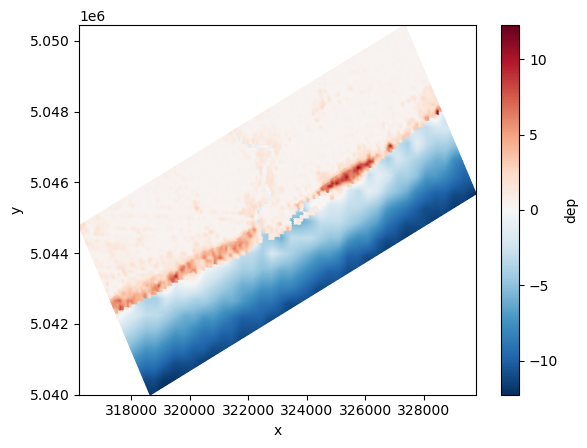

In [13]:
sf_qt.quadtree.data["dep"].ugrid.plot()

Continue with the mask for the QuadTree grid; we aim to have the same active extent as the regular grid in different ways:
- Based on elevation
- Bu using an include polygon

In [14]:
# add the gdf mask_include to gdf_refinement as combined gdf
mask_include = gpd.GeoDataFrame(pd.concat([sf.region, gdf_refinement], ignore_index=True))

# create a new buffer that most includes the open boundary
gdf_osm_buf2 = gdf_osm_buf.buffer(2000, cap_style=3)
open_include = gpd.GeoDataFrame(geometry=gdf_osm_buf2, crs=sf_qt.crs)

In [15]:
# sf_qt.quadtree.setup_mask(include_polygon=mask_include, open_boundary_polygon=open_include, open_boundary_zmax=-3)

In [16]:
# sf_qt.setup_mask_active(include_mask=mask_include, all_touched=False)

In [17]:
#NOTE we lose performance through the SfincsModel, I expect this to come from the data_catalog that parses the geodataframes
# sf_qt.quadtree.setup_mask_active(gdf_include=mask_include, all_touched=False)
sf_qt.quadtree.setup_mask_active(zmin=-5, reset_mask=True, all_touched=False)


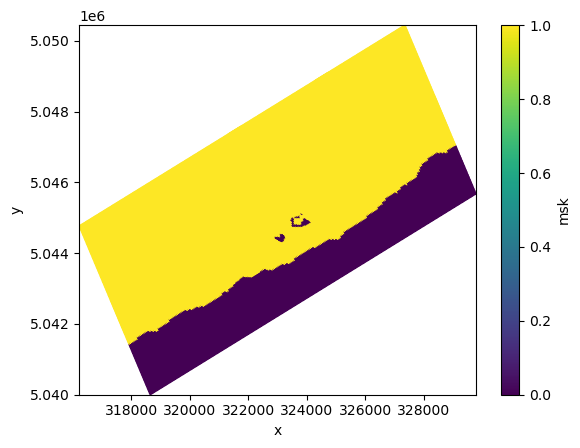

In [18]:
sf_qt.quadtree.data["msk"].ugrid.plot()

In [19]:
sf_qt.setup_mask_bounds(btype="waterlevel", include_mask=open_include, zmax=-3, reset_bounds=True)

2024-03-25 12:40:02,871 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [12.646, 45.490, 12.820, 45.586] (EPSG:4326)
2024-03-25 12:40:02,878 - sfincs_quadtree - quadtree - DEBUG - waterlevel (mask=2) boundary cells reset.


In [22]:
%matplotlib qt
# %matplotlib inline

sf_qt.quadtree.data["msk"].ugrid.plot()

2024-03-25 12:40:08,513 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [12.646, 45.490, 12.820, 45.586] (EPSG:4326)
2024-03-25 12:40:08,521 - sfincs_quadtree - quadtree - DEBUG - waterlevel (mask=2) boundary cells reset.


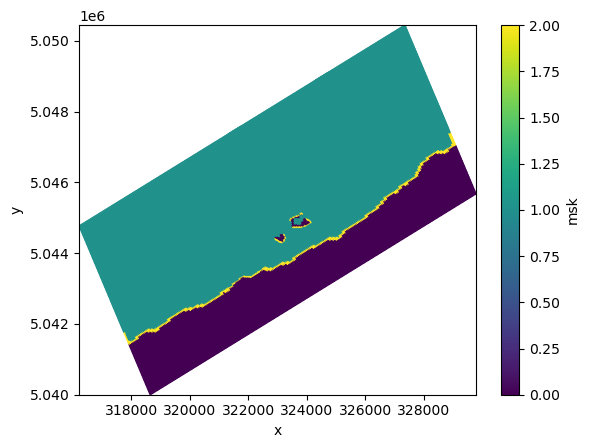

In [21]:
%matplotlib qt
# %matplotlib inline
sf_qt.setup_mask_bounds(btype="waterlevel", include_mask=open_include, zmax=-3, reset_bounds=True, connectivity=4)
sf_qt.quadtree.data["msk"].ugrid.plot()

In [21]:
# sf_qt.quadtree.setup_mask_active(model="snapwave", gdf_include= mask_include)#, gdf_exclude= new_exclude)#, gdf_include= include

# sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()
# plt.axis('equal')

In [22]:
# plot the difference between the mask (original code) and the msk (new code)
# NOTE with all_touched=True, there is a small difference
# (sf_qt.quadtree.data["mask"]-sf_qt.quadtree.data["msk"]).ugrid.plot()

In [23]:
# drop the mask variable from the quadtree data
# sf_qt.quadtree.data = sf_qt.quadtree.data.drop("mask")

## Now some snapwave functionalities

2024-03-25 12:32:11,049 - sfincs_quadtree - quadtree - INFO - Building mask ...
2024-03-25 12:32:11,050 - sfincs_quadtree - quadtree - INFO - Build new mask for: snapwave ...


(315542.82929009537, 330465.9030886527, 5039477.911692442, 5050963.85445871)

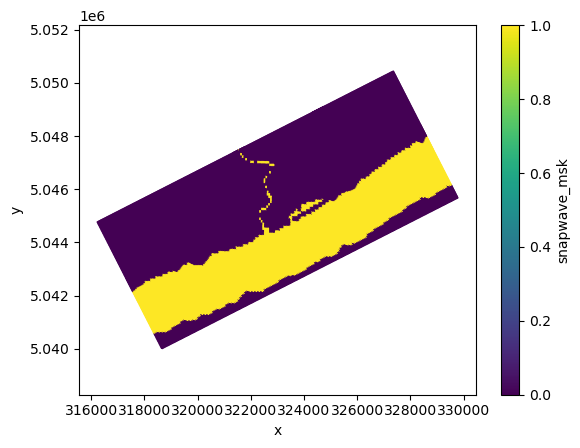

In [24]:
sf_qt.setup_mask_active(model="snapwave", zmin=-10, zmax=0)#, include_mask=gdf_riv_buf)
sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()
plt.axis('equal')


Try situation where we want to directly copy the SFINCS mask to SnapWave:

In [28]:
%matplotlib qt
# %matplotlib inline
# import importlib
# from hydromt_sfincs import quadtree
# importlib.reload(quadtree)

sf_qt.setup_mask_bounds(model="snapwave", include_mask=open_include, zmax=-4, copy_sfincsmask=False, connectivity=4)
sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

plt.axis('equal')

2024-03-25 12:35:33,129 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [12.646, 45.490, 12.820, 45.586] (EPSG:4326)


(315542.82929009537, 330465.9030886527, 5039477.911692442, 5050963.85445871)

In [ ]:
sf_qt.quadtree.data

### Now create a subgrid table for this model

In [ ]:
sf_qt.setup_subgrid(datasets_dep=datasets_dep, buffer_cells=40)

### Add some random boundary conditions

In [ ]:
# x&y-locations in same coordinate reference system as the grid:
x = [319526, 329195]
y = [5041108, 5046243]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

# In this case we will provide 3 values (periods=3) between the start (tstart=20100201 000000) and the end (tstop=20100201 120000) of the simulation:
time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=3,
)

# add some water levels
bzs = [[0, 0.25], [0.75, 1.0], [0, 0.25]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)

# Actually add it to the SFINCS model class:
sf_qt.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)


In [ ]:
# We now use the previously created src discharge points for the regular model
gdf = sf.forcing["dis"].vector.to_gdf()

# make up some discharge data
index = sf.forcing["dis"].index
dis = np.array([[2.0, 1.0], [5.0, 2.0], [2.0, 1.0]])
dispd = pd.DataFrame(index=time, columns=index, data=dis)

# now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
sf_qt.setup_discharge_forcing(timeseries=dispd, locations=gdf)

# # NOTE: the discharge forcing data is now stored in the sf.forcing dictionary
sf_qt.forcing.keys()

### And save everything we build sofar

In [ ]:
# this is needed for stability?
#TODO check wheterh we have a stable solution in the end; seems to be unstable at the jumps in resolution
sf_qt.config["tspinup"] = 3600
sf_qt.config["alpha"] = 0.4

In [ ]:
sf_qt.write()

Run and read results, make plots and animation

In [ ]:
import xugrid as xu
uds = xu.open_dataset(r"c:\github\hydromt_sfincs\examples\test_quadtree\sfincs_map.nc")

In [ ]:
uds["zb"].ugrid.plot()

In [ ]:
uds["zsmax"].max(dim="timemax").ugrid.plot(vmax=2)

In [ ]:
# plot rough estimation of water depth
h = uds["zsmax"].max(dim="timemax") - uds["zb"]

h = h[h>0.1]

h.ugrid.plot()

In [ ]:
# create zs plot and save to mod.root/figs/sfincs_zs.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
da_zs = uds["zs"]

def update_plot(i, da_zs, cax_zs):
    da_zsi = da_zs.isel(time=i)
    t = da_zsi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water level {t}")
    cax_zs.set_array(da_zsi.values.ravel())

fig, ax = plt.subplots(figsize=(11, 7))
cax_zs = da_zs.isel(time=0).ugrid.plot(
    ax=ax, vmin=0, vmax=3, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_zs.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_zs,
        cax_zs,
    ),
)

# to save to mp4
# ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())

In [ ]:
uds["msk"].where(uds["msk"]==2, np.nan).ugrid.plot()